# CS4035 - Cyber Data Analytics
## Lab 4

### Submit on brightspace (zip file with the name Group_xx.zip)
This jupyter file completed with code, plots, figures and report for each question. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.

(if you used hard-to-get libraries) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 42

## Student 1 
### Name : Otte Van Dam
### ID : 5096790

## Student 2
### Name : Suhaib Basir
### ID : 5059151

## README

Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

The batch size was chosen based on a graph that can be found in section 4. It had the highest accuracy for the models.

## 1. Preparation (0 points)
### Load imports

In [44]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from tqdm import tqdm

### 1a. Load the dataset and split it into a train and test set

In [45]:
X = np.load('X.npy')
y = np.load('y.npy')

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = SGDClassifier(loss='log_loss', random_state=42)

# Fit the model to the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy before attack:", accuracy)

Accuracy before attack: 0.9164473684210527


## 2. Attacking linear models (5 Points)

### 2a. Implementing useless import attacks


In [47]:
def evade(sample, coef):
    # For every coefficient smaller than 0 we include the import
    for i, c in enumerate(coef):
        if c < 0:
            sample[i] = 1
    return sample

def create_attack(X, y, coef):
    X_attack = []
    for i in range(len(X)):
        sample = X[i]
        # Only if the sample is malicious, we use useless imports
        if y[i] == 1:
            X_attack.append(evade(sample, coef[0]))
        else:
            X_attack.append(sample)
    return X_attack

In [48]:
X_test_attack = create_attack(X_test, y_test, model.coef_)
# Predict on the test set that has been altered
y_pred_attack = model.predict(X_test_attack)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_attack)
print("Accuracy after attack:", accuracy)

Accuracy after attack: 0.446875


### 2b. Analysis and answers to the questions
The accuracy drops from almost 92% to 44%. This shows that the model is not robust at all. At this point a random classifier will perform better than the SGDC when attacked.

## 3. Improving robustness by hardening (5 Points)

### 3a. Implementing hardening

In [49]:
def hardening(batch_size, attack_on_test, track_accuracy_during_training):
    model_hardening = SGDClassifier(loss='log_loss', random_state=42)

    # Reset train and test data to avoid changes made during the creation of the attack
    # A random seed is set so this does have differences in the train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    num_batches = len(X_train) // batch_size
    # Set coefficients to 0 to use for the attack of the first run.
    coef_hardened = [[0] * len(X_train[0])]
    accuracy_during_training = []
    for batch in (range(num_batches)) if not track_accuracy_during_training else tqdm(range(num_batches)):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        # Get samples with useless imports
        X_batch_attack = create_attack(X_batch, y_batch, coef_hardened)
        # Fit model
        model_hardening.partial_fit(X_batch_attack, y_batch, classes=np.unique(y_train))
        # Store coefficients for attack of next run and use them for the attack during training
        coef_hardened = model_hardening.coef_
        if track_accuracy_during_training and batch % 600 == 0:
            # Create attacked test set
            X_test_attack_hardened = create_attack(X_test, y_test, coef_hardened)

            # Predict on the attacked test set
            y_pred_hardened = model_hardening.predict(X_test_attack_hardened)

            accuracy_hardened = accuracy_score(y_test, y_pred_hardened)
            accuracy_during_training.append(accuracy_hardened)

            # Reset train and test data to avoid changes made during the creation of the attack
            # A random seed is set so this does have differences in the train and test set
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    if attack_on_test:
        X_test_attack_hardened = create_attack(X_test, y_test, coef_hardened)
        y_pred_hardened = model_hardening.predict(X_test_attack_hardened)
        accuracy_hardened = accuracy_score(y_test, y_pred_hardened)
        return accuracy_hardened, accuracy_during_training
    else:
        y_pred_hardened = model_hardening.predict(X_test)
        accuracy_hardened = accuracy_score(y_test, y_pred_hardened)
        return accuracy_hardened, accuracy_during_training

In [50]:
batch_sizes = [2, 4, 8, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90, 120, 140]
accuracy_list_hardening = []
for batch_size in tqdm(batch_sizes):
    accuracy_list_hardening.append(hardening(batch_size, True, False)[0])

# Reset train and test data to avoid changes made during the creation of the attack
# A random seed is set so this does have differences in the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracy_no_attack, _ = hardening(4, False, False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracy_attack, accuracy_during_training_hardening = hardening(4, True, True)

print('Accuracy with attack on test set: ', accuracy_attack)
print('Accuracy without attack: ', accuracy_no_attack)

100%|██████████| 6079/6079 [02:16<00:00, 44.43it/s] 


Accuracy with attack on test set:  0.8131578947368421
Accuracy without attack:  0.8254934210526316


### 3b. Analysis and answers to the questions

After hardening, the model still achieves a decent accuracy when attacked. This however is paired with a lower accuracy when not attacked compared to the normal SGD classifier. This makes the model more robust since the difference between the accuracy when attacked is not much different from the accuracy when not attacked.

## 4. Training non-negative linear models (5 Points)

### 4a. Implement non-negative logistic regression using SGD

In [51]:
def non_negative(batch_size, attack_on_test, track_accuracy_during_training):
    model_non_negative = SGDClassifier(loss='log_loss', random_state=42)

    # batch_size = 24
    num_batches = len(X_train) // batch_size

    accuracy_during_training = []

    for batch in (range(num_batches)) if not track_accuracy_during_training else tqdm(range(num_batches)):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        model_non_negative.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        coef_non_negative = model_non_negative.coef_

        # Clip the coefficients to 0 or above
        for i in range(len(coef_non_negative[0])):
            if coef_non_negative[0][i] < 0:
                coef_non_negative[0][i] = 0

        model_non_negative.coef_ = coef_non_negative
        if track_accuracy_during_training and batch % 600 == 0:

            # Create attacked test set
            X_test_attack_non_negative = create_attack(X_test, y_test, coef_non_negative)

            # Predict on attacked test set
            y_pred_non_negative = model_non_negative.predict(X_test_attack_non_negative)

            # Store accuracy per run
            accuracy_during_training.append(accuracy_score(y_test, y_pred_non_negative))

    if attack_on_test:

        # Get the coefficients for the attack
        coef_non_negative = model_non_negative.coef_

        # Create attacked test set
        X_test_attack_non_negative = create_attack(X_test, y_test, coef_non_negative)

        # Predict on attacked test set
        y_pred_non_negative = model_non_negative.predict(X_test_attack_non_negative)

        accuracy_non_negative = accuracy_score(y_test, y_pred_non_negative)

        return accuracy_non_negative, accuracy_during_training

    else:
        # Predict on normal test set
        y_pred_non_negative = model_non_negative.predict(X_test)
        accuracy_non_negative = accuracy_score(y_test, y_pred_non_negative)

        return accuracy_non_negative, accuracy_during_training

In [52]:
batch_sizes = [2, 4, 8, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90, 120, 140]
accuracy_list_non_negative = []
# Run on different batch sizes to find the best batch size for the highest accuracy
# Graph can be found below
for batch_size in tqdm(batch_sizes):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    accuracy_list_non_negative.append(non_negative(batch_size, True, False)[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracy_no_attack, _ = non_negative(4, False, False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracy_attack, accuracy_during_training_non_negative = non_negative(4, True, True)

print('Accuracy with attack on test set: ', accuracy_attack)
print('Accuracy without attack: ', accuracy_no_attack)

100%|██████████| 6079/6079 [02:21<00:00, 42.90it/s] 


Accuracy with attack on test set:  0.8223684210526315
Accuracy without attack:  0.8223684210526315


### Plot to find the best batch size per model

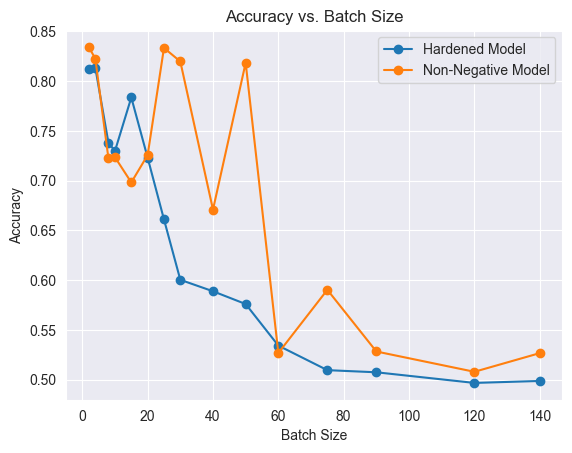

In [53]:
# Plot the accuracies for each batch size
plt.plot(batch_sizes, accuracy_list_hardening, marker='o', label='Hardened Model')
plt.plot(batch_sizes, accuracy_list_non_negative, marker='o', label='Non-Negative Model')

# Add labels and title to the plot
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch Size')

# Add legend
plt.legend()

# Show the plot
plt.show()

### Plot for accuracy per epoch

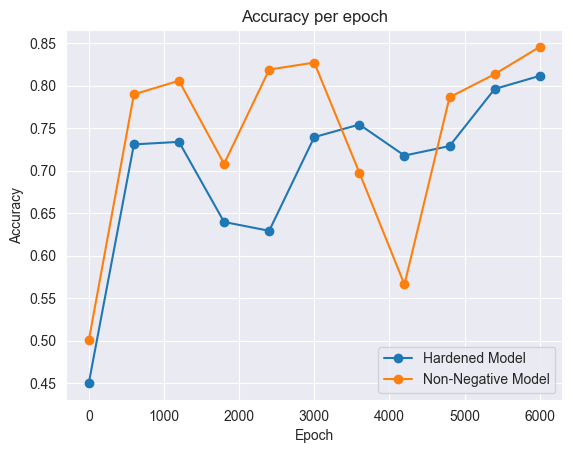

In [54]:
x_axis = []
for i in range(len(accuracy_during_training_hardening)):
    x_axis.append(i * 600)

# Plot the accuracies for each batch size
plt.plot(x_axis, accuracy_during_training_hardening, marker='o', label='Hardened Model')
plt.plot(x_axis, accuracy_during_training_non_negative, marker='o', label='Non-Negative Model')

# Add labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')

# Add legend
plt.legend()

# Show the plot
plt.show()

### 4b. Analysis and answers to the questions.

The non-negative classifier is even more robust than the hardened model since there is no difference between the test set that is attacked and the test set that is not attacked. This is because the attacker can not attack with useless imports since adding imports will only make a sample more likely to be seen as malicious. The downside of this is that benign samples with a lot of imports are likely to be flagged as malicious even though they are not. It can also be seen in the accuracy per epoch graph that the non-negative model will have a higher accuracy faster than the hardened model. The non-negative classifier only has to set the negative coefficients to zero and make the intercept higher. The hardened model gets constantly gets training data that is adapting to its coefficients and has to adapt to that. This is a process that takes more time.

## 5. Bonus: robust decision trees for fraud detection (5 Points)

### 5a. Train and analyze a regular decision tree for fraud detection

### 5b. Train and analyze a robust decision tree (GROOT) for fraud detection

### 5c. Evaluate the robustness of the two models